In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/df_eddies_processed_1462_10650.pkl')

with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)
    
import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import smooth, tilt_distance_LI


In [2]:
# sample_eddies = [1917, 474, 971, 1978, 33, 207, 1783, 2370]
sample_eddies = [66, 425, 871, 1780, 31, 182, 1602, 2128]

dic_sample = {}
for eddy in sample_eddies:
    eddy = f'Eddy{eddy}'
    dic_sample[eddy] = dic_eddies_vert[eddy]

# with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Eddy_Data/Vertical_Eddy_Dataset/dic_vert_eddies_sample.pkl', 'rb') as f:
#     dic_sample = pickle.load(f)


In [3]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [4]:
# Unique colors for each eddy
colors = [c for i, c in enumerate(plt.get_cmap("tab10").colors) if i != 7]


Text(0, 0.5, 'Latitude (°N)')

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


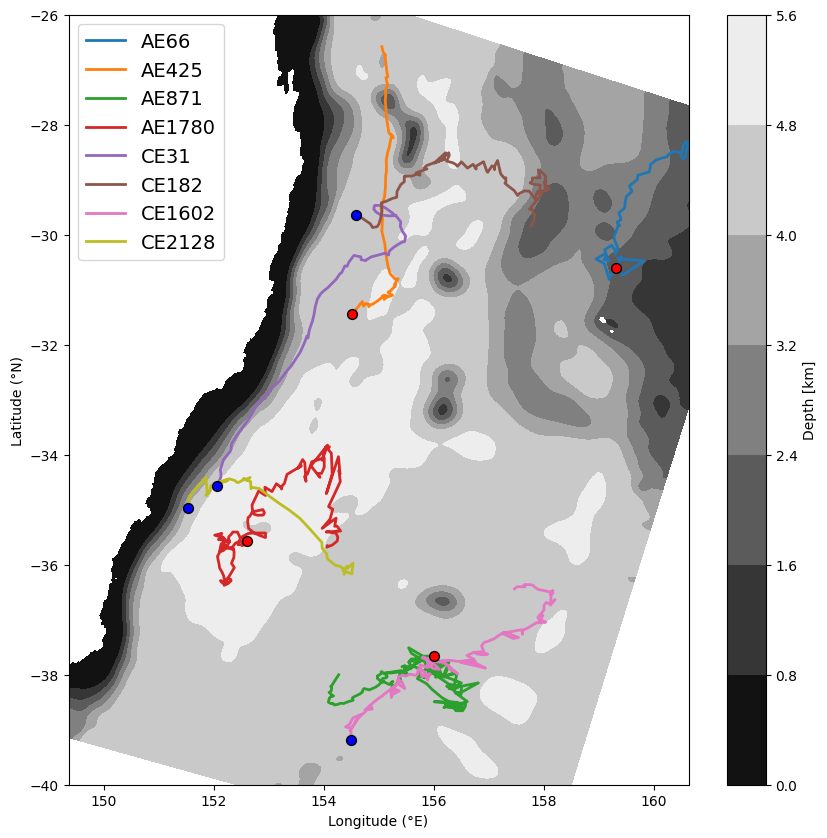

In [5]:
plt.figure(figsize=(10,10))
plt.contourf(lon_rho, lat_rho, np.where(mask_rho, h, np.nan)/1000, cmap='gray')
plt.colorbar(label='Depth [km]')

for e, eddy in enumerate(sample_eddies):

    df = df_eddies[df_eddies.Eddy==eddy].copy()
    cyc = df.iloc[0].Cyc
    plt.plot(df['Lon'], df['Lat'], label=f'{cyc}{eddy}',
            linewidth=2, color=colors[e%len(colors)])
    plt.scatter(df.iloc[-1]['Lon'], df.iloc[-1]['Lat'], edgecolors='k',
                color='r' if cyc=='AE' else 'b', zorder=10, s=50)

plt.legend(loc='upper left', fontsize=14)
plt.axis('equal')
plt.xlim(150, 160)
plt.ylim(-40, -26)
plt.xlabel('Longitude (°E)')
plt.ylabel('Latitude (°N)')


#### Side Profiles

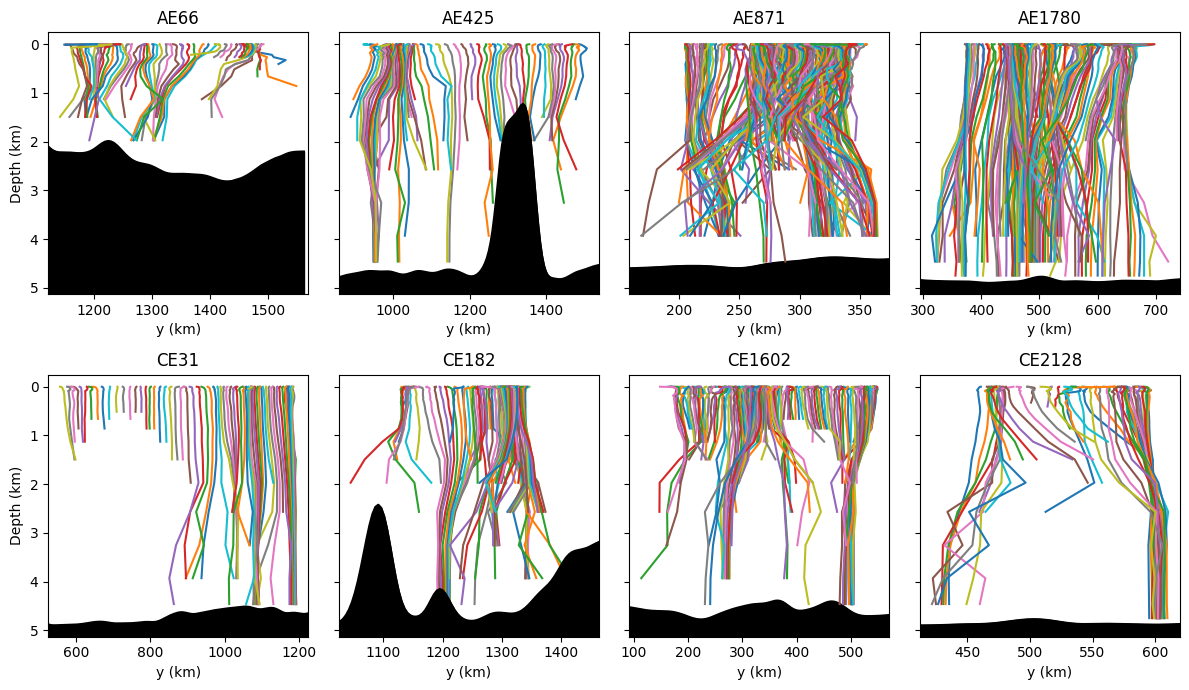

In [6]:
fig, axs = plt.subplots(2, 4, figsize=(12,7), sharey=True)
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    if eddy in [971, 207, 2370]:
        flagx = True
    else:
        flagx = False
    days = dic_sample[f'Eddy{eddy}']
    df_all = pd.concat(
        [df0 for df0 in days.values() if not df0.empty and not df0.isna().all().all()],
        ignore_index=True
    )
    df_mean = pd.DataFrame([{
        'Eddy': eddy,
        'x_mean': df_all['x'].mean(),
        'y_mean': df_all['y'].mean()
    }])
    
    dic = dic_sample[f'Eddy{eddy}']
    pmean = df_mean[df_mean.Eddy==eddy].iloc[0]
    for d, day in enumerate(dic.keys()):
        df = dic[day].copy()
        if len(df):
            if flagx:
                ax.plot(df.x, -df.Depth/1000, zorder=0 if df.iloc[-1].y > pmean.y_mean else 2)
                ax.set_xlabel('x (km)')
            else:
                ax.plot(df.y, -df.Depth/1000, zorder=2 if df.iloc[-1].x > pmean.x_mean else 0)
                ax.set_xlabel('y (km)')
    xlim = ax.get_xlim()

    if flagx:
        jc = np.where(np.abs(pmean.y_mean-y_grid)==np.min(np.abs(pmean.y_mean-y_grid)))[0][0]
        ax.plot(x_grid, h[:, jc]/1000, 'k', zorder=1)
        ylim = ax.get_ylim()
        ax.fill_between(x_grid, h[:, jc] / 1000, 10, color='k', zorder=1)
    else:
        ic = np.where(np.abs(pmean.x_mean-x_grid)==np.min(np.abs(pmean.x_mean-x_grid)))[0][0]
        ax.plot(y_grid, h[ic, :]/1000, 'k', zorder=1)
        ylim = ax.get_ylim()
        ax.fill_between(y_grid, h[ic, :] / 1000, 10, color='k', zorder=1)
    
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
axs[0,0].set_ylabel('Depth (km)')
axs[1,0].set_ylabel('Depth (km)')
axs[0,0].invert_yaxis()
plt.tight_layout()


#### Depths

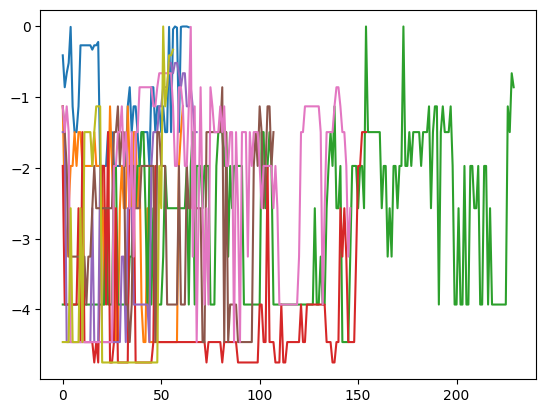

In [7]:
for e, eddy in enumerate(dic_sample.keys()):
    dic = dic_sample[eddy]
    depths = []
    for d, day in enumerate(dic.keys()):
        df = dic[day].copy()
        if len(df):
            depths.append(-df.iloc[-1]['Depth']/1000)
        else:
            depths.append(0)
    plt.plot(-np.array(depths), color=colors[e])


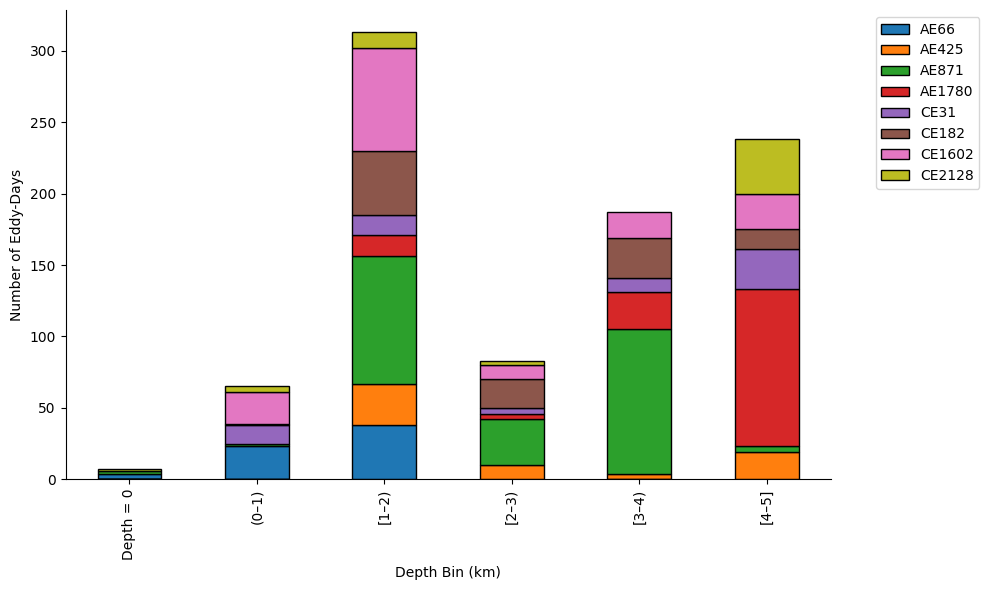

In [8]:
# Adjustable bin width
bin_width = 1  # km
max_depth_km = 5  # adjust as needed

# Create bin edges
edges = np.arange(0, max_depth_km + bin_width, bin_width)

# Labels: Depth=0 | (0–1) | [1–2) ... [4–5]
def _fmt(x):
    return f"{x:.0f}" if float(bin_width).is_integer() else f"{x:.1f}"

bin_labels = (["Depth = 0",
               f"({_fmt(edges[0])}–{_fmt(edges[0] + bin_width)})"]
              + [f"[{_fmt(b)}–{_fmt(b+bin_width)})" for b in edges[1:-1]])
bin_labels[-1] = f"[{_fmt(edges[-2])}–{_fmt(edges[-1])}]"

# Prepare DataFrame
eddies = [int(eddy[4:]) for eddy in list(dic_sample.keys())]
cycs = []
for eddy in eddies:
    cycs.append(df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc)
eddy_names = [cycs[k]+str(eddies[k]) for k in range(len(eddies))]

bin_counts = pd.DataFrame(0, index=bin_labels, columns=eddy_names)

# Fill in counts
for e, eddy in enumerate(eddy_names):
    dic = dic_sample[f'Eddy{eddy[2:]}']
    depths = []
    for day in dic:
        df = dic[day].copy()
        if len(df):
            depth_km = -df.iloc[-1]['Depth'] / 1000
            depths.append(depth_km)
        else:
            depths.append(0)

    depths = np.array(depths)

    # Separate exact zeros so they don’t get included in (0–1)
    zero_count = np.isclose(depths, 0).sum()
    nonzero = depths[~np.isclose(depths, 0)]

    counts, _ = np.histogram(nonzero, bins=edges)
    counts = np.insert(counts, 0, zero_count)  # prepend Depth=0 bin
    bin_counts.loc[:, eddy] = counts

# Plot
bin_counts.plot(kind='bar', stacked=True, figsize=(10, 6),
                edgecolor='black', color=colors)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Depth Bin (km)')
plt.ylabel('Number of Eddy-Days')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


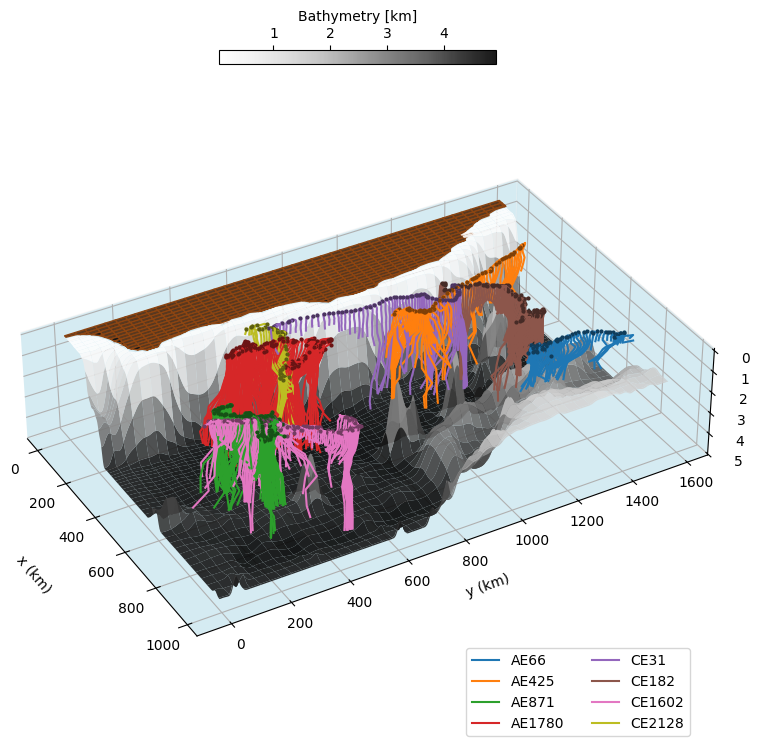

In [9]:
from matplotlib.colors import to_rgb

def darken(color, factor=0.7):
    r, g, b = to_rgb(color)
    return (r*factor, g*factor, b*factor)

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111, projection='3d')

ax.xaxis.pane.set_facecolor("lightblue")
ax.yaxis.pane.set_facecolor("lightblue")
ax.zaxis.pane.set_facecolor("lightblue")

# --- plot bathymetry and keep reference ---
ax.plot_surface(
    X_grid, Y_grid, np.where(mask_rho==0, 0, np.nan),
    facecolors=np.where(mask_rho==0, 'saddlebrown', 'none'),
    edgecolor="saddlebrown",
    alpha=0.9, zorder=10
)

surf = ax.plot_surface(
    X_grid, Y_grid, np.where(mask_rho, h, np.nan)/1000 + .01,
    cmap="Greys", edgecolor="none",
    alpha=0.9, zorder=0
)

for e, (eddy, dic) in enumerate(dic_sample.items()):
    for d, (day, df) in enumerate(dic.items()):
        # df = df.copy()
        # df = df[df.Depth.abs() < 1000]
        if len(df):
            if d == 0: 
                cyc = df_eddies[df_eddies.Eddy==int(eddy[4:])].iloc[0].Cyc

                ax.plot(df.x, df.y, -df.Depth/1000,
                        zorder=Y_grid.max()-round(df.iloc[0].y),
                        color=colors[e % 9], label=f'{cyc}{int(eddy[4:])}')
            else:

                ax.plot(df.x, df.y, -df.Depth/1000,
                        zorder=Y_grid.max()-round(df.iloc[0].y),
                        color=colors[e % 9])

for e, (eddy, dic) in enumerate(dic_sample.items()):
    for d, (day, df) in enumerate(dic.items()):
        # df = df.copy()
        # df = df[df.Depth.abs() < 1000]
        darker_color = darken(colors[e % len(colors)], 0.5)  # 60% brightness
        if len(df):
            ax.plot(
                df.iloc[0].x, df.iloc[0].y, -df.iloc[0].Depth/1000,
                color=darker_color, marker='.', markersize=4,
                zorder=Y_grid.max()-round(df.iloc[0].y)
            )
        else:
            data = df_eddies[df_eddies.Eddy==int(eddy[4:])].iloc[0]
            ax.plot(
                data.xc, data.yc, -z_r[0]/1000,
                color=darker_color, marker='.', markersize=4,
                zorder=Y_grid.max()-round(data.yc)
            )

ax.invert_zaxis()

# --- equal aspect without wasting space ---
xlims = ax.get_xlim()
ylims = ax.get_ylim()
zlims = ax.get_zlim()
dx, dy, dz = xlims[1]-xlims[0], ylims[1]-ylims[0], zlims[1]-zlims[0]
ax.set_box_aspect([dx, dy, 400])

# view angle
# ax.view_init(elev=35, azim=-40)
ax.view_init(elev=35, azim=-30)

ax.set_xlabel("x (km)", labelpad=15)
ax.set_ylabel("y (km)", labelpad=15)
ax.set_zlabel("Depth (km)")
ax.legend(loc='lower right', ncol=2)

# cbar = fig.colorbar(surf, ax=ax, orientation="horizontal", shrink=0.1, pad=0.07, location='top')
cbar = fig.colorbar(
    surf,
    ax=ax,
    orientation="horizontal",
    pad=0,
    fraction=0.02,
    aspect=20,
    location='top'
)
cbar.set_label("Bathymetry [km]")

plt.show()


#### Ellipticity

##### Depth

In [10]:
df_means = pd.DataFrame([
    {
        'Eddy': eddy,
        'x_mean': df_all['x'].mean(),
        'y_mean': df_all['y'].mean()
    }
    for eddy, days in dic_sample.items()
    for df_all in [pd.concat(
        [df0 for df0 in days.values() 
         if not df0.empty and not df0.isna().all().all()],
        ignore_index=True
    )]
])


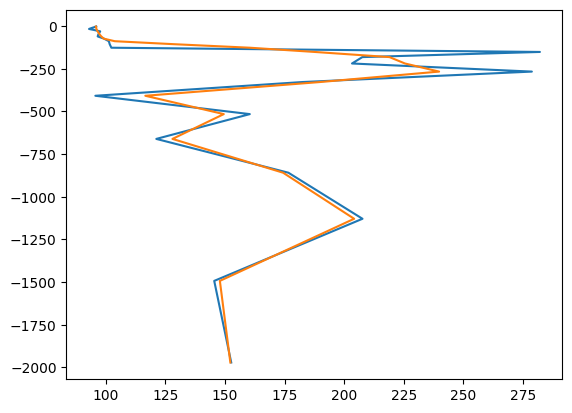

In [11]:
k = 0
for eddy in sample_eddies:
    eddy = f'Eddy{eddy}'
    
    dic = dic_sample[eddy]

    for day in dic.keys():
        df = dic[day]

        if len(df):

            Qs = df['Q'].values.copy()
            Rcs = df['Rc'].values.copy()
            psi0s = df['psi0'].values.copy()
            Rs = df['R'].values.copy()
            depths = -df['Depth'].values.copy() / 1000  # in km
            
            # smooth against frame index t
            window = 50
            sq11  = smooth([q[0,0] for q in Qs], depths, num=1000, window=window)
            sq12  = smooth([q[0,1] for q in Qs], depths, num=1000, window=window)
            sq22  = smooth([q[1,1] for q in Qs], depths, num=1000, window=window)
    
            df['sw'] = 2 * (sq11 + sq22)
            df['sQ'] = [np.array([[sq11[i], sq12[i]], [sq12[i], sq22[i]]]) for i in range(len(sq11))]
            
            df['sRc']   = smooth(Rcs,                    depths, window=window)
            df['spsi0'] = smooth(psi0s,                  depths, window=window)
            df['sR']   = smooth(Rs,                    depths, window=window)
            
            if k == 100:
                plt.figure()
                plt.plot(df.Rc, df.Depth)
                plt.plot(df.sRc, df.Depth)
                plt.show

            k += 1
            

In [12]:
[round(a) for a in np.linspace(0, 64, 6)]


[0, 13, 26, 38, 51, 64]

In [13]:
days_me = [np.array([0, 17, 26, 37, 51]),
    np.array([ 0,  5, 10, 17, 24, 28, 31, 41, 58]),
 np.array([  5,  30, 47,  76,  127, 135]),
 np.array([30,  51,  68, 103, 137]),
 
 np.array([ 2, 16, 30, 38, 44, 49, 55, 59, 62, 68]),
 np.array([  0,    36,  45,  55,  63,  79,  89, 107]),
 np.array([  10,  33,  44,  50, 66, 114, 130, 145]),
 np.array([ 0,  16, 19, 21, 25, 40, 49, 56])]

days_p = []
for e, (eddy, dic) in enumerate(dic_sample.items()):
   
    days = np.array(list(dic.keys()))[days_me[e]]
    days_p.append(days)


In [14]:
def quad_solver(xc, yc, q11, q12, q22, Rc, y0):
    q11, q22 = np.abs(q11.copy()), np.abs(q22.copy())

    a = q11
    b = -2*q11*xc + 2*q12*(y0-yc)
    c = q11*xc**2 - 2*q12*xc*(y0-yc) + q22*(y0-yc)**2 - Rc**2/2

    if b**2-4*a*c >= 0:
        root1 = (-b-np.sqrt(b**2-4*a*c))/(2*a)
        root2 = (-b+np.sqrt(b**2-4*a*c))/(2*a)
    else:
        root1, root2 = np.nan, np.nan
    return root1, root2 


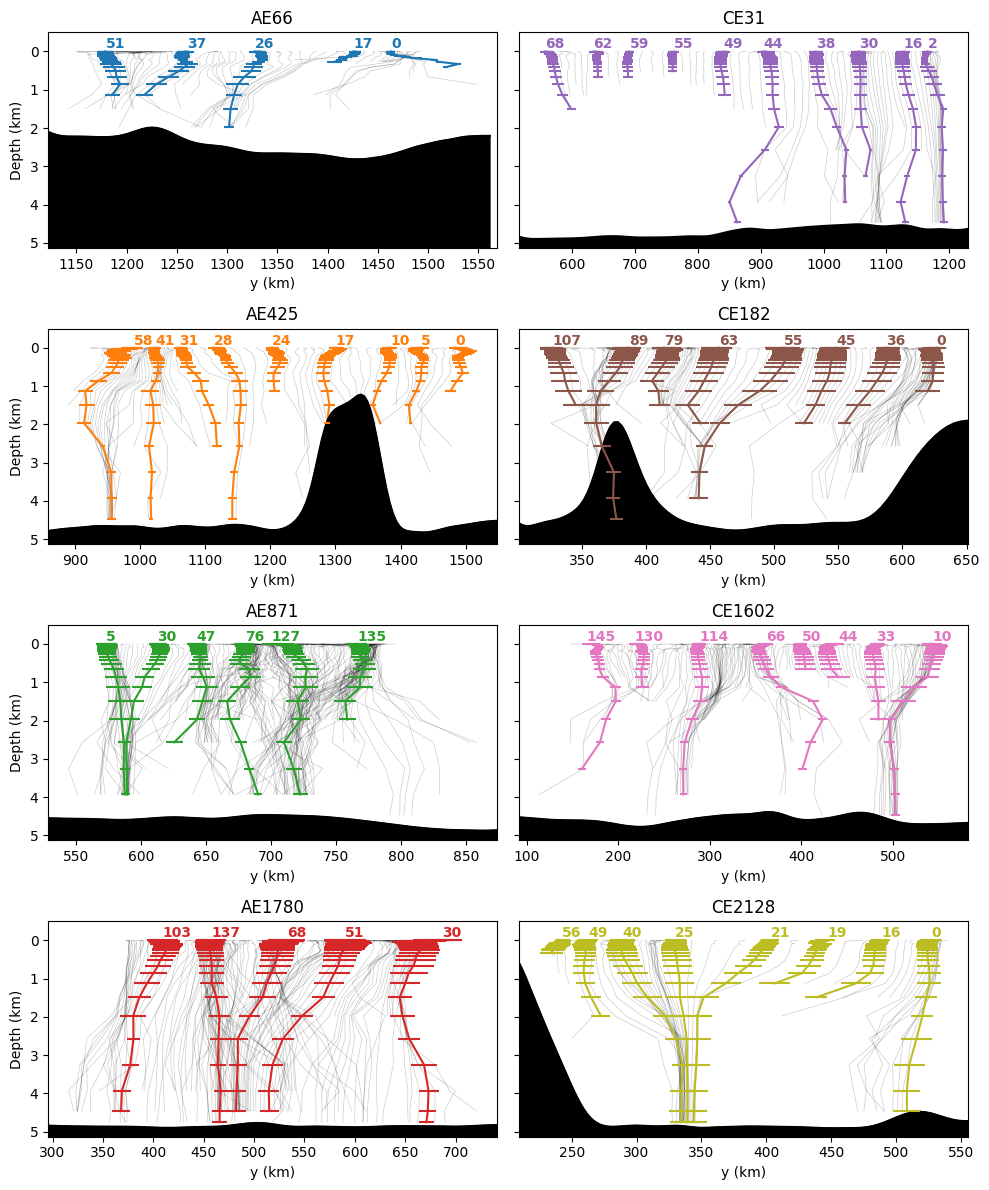

In [15]:
fig, axs = plt.subplots(4, 2, figsize=(10,12), sharey=True)

colors_v = plt.get_cmap('tab10').colors
for e, eddy in enumerate(sample_eddies):
    ax = axs[e % 4, e // 4]
    if eddy in [871, 182, 2128]:
        flagx = True
    else:
        flagx = False
    days = dic_sample[f'Eddy{eddy}']
    df_all = pd.concat(
        [df0 for df0 in days.values() if not df0.empty and not df0.isna().all().all()],
        ignore_index=True
    )
    df_mean = pd.DataFrame([{
        'Eddy': eddy,
        'x_mean': df_all['x'].mean(),
        'y_mean': df_all['y'].mean()
    }])
    
    dic = dic_sample[f'Eddy{eddy}']
    pmean = df_mean[df_mean.Eddy==eddy].iloc[0]
    day_idx = 0
    for d, day in enumerate(dic.keys()):
        df = dic[day].copy()
        if len(df):
            if flagx:
                ax.plot(df.x, -df.Depth/1000, linewidth=.5, color='k', alpha=.2,
                            zorder=-1)
                ax.set_xlabel('x (km)')
            else:
                ax.plot(df.y, -df.Depth/1000, linewidth=.5, color='k', alpha=.2,
                            zorder=-1)

            if day in days_p[e]:

                if flagx:
                    ax.plot(df.x, -df.Depth/1000, color=colors[e % 10],
                            zorder=0 if df.iloc[-1].y > pmean.y_mean else 2)
                else:
                    ax.plot(df.y, -df.Depth/1000, color=colors[e % 10],
                            zorder=2 if df.iloc[-1].x > pmean.x_mean else 0)

                # raw data
                xs = df['x'].values.copy()
                ys = df['y'].values.copy()
                sQs = df['sQ'].values.copy()
                sq11 = [q[0,0] for q in sQs]
                sq12 = [q[0,1] for q in sQs]
                sq22 = [q[1,1] for q in sQs]
                sRc = df['sRc'].values.copy()
                sR = df['sR'].values.copy()
                spsi0 = df['spsi0'].values.copy()
                depths = -df['Depth'].values.copy() / 1000  # in km

                # root1s, root2s = [], []
                # data_surf = df_eddies[(df_eddies.Eddy==eddy) & (df_eddies.Day==int(day[3:]))]
                # if data_surf.empty:
                #     root1s = [np.nan]*len(depths)
                #     root2s = [np.nan]*len(depths)
                # else:
                #     ic = int(data_surf.ic.iloc[0])
                #     jc = int(data_surf.jc.iloc[0])
                
                #     def to_float(x):
                #         a = np.asarray(x)
                #         return np.nan if a.size==0 else float(a.ravel()[0])
                
                #     for xc, yc, q11, q12, q22, Rc, z0 in zip(xs, ys, sq11, sq12, sq22, sRc, depths):
                #         c = float(y_grid[jc]) if flagx else float(x_grid[ic])
                #         r1, r2 = quad_solver(xc, yc, q11, q12, q22, Rc, c)
                #         root1s.append(to_float(r1))
                #         root2s.append(to_float(r2))
                
                # root1s = np.asarray(root1s, dtype=float)
                # root2s = np.asarray(root2s, dtype=float)
                
                # ax.plot(root1s, depths, color=colors[e % 10], alpha=0.8,
                #             zorder=0 if df.iloc[-1].y > pmean.y_mean else 2)
                # ax.plot(root2s, depths, color=colors[e % 10], alpha=0.8,
                #             zorder=0 if df.iloc[-1].y > pmean.y_mean else 2)

                for xc, yc, q11, q12, q22, Rc, R, z0 in zip(xs, ys, sq11, sq12, sq22, sRc, sR, depths):
                    R /= 7
                    if flagx:
                        ax.hlines(z0, xc-R, xc+R, color=colors[e % 10])
                    else:
                        ax.hlines(z0, yc-R, yc+R, color=colors[e % 10])

                if flagx:
                    ax.text(xs[0], -.08, d, color=colors[e % 10], fontweight='bold')
                else:
                    ax.text(ys[0], -.08, d, color=colors[e % 10], fontweight='bold')
                    
                day_idx += 1
    
    ax.set_xlabel('y (km)')
    xlim = ax.get_xlim()

    if flagx:
        jc = np.where(np.abs(pmean.y_mean-y_grid)==np.min(np.abs(pmean.y_mean-y_grid)))[0][0]
        ax.plot(x_grid, h[:, jc]/1000, 'k', zorder=1)
        ylim = ax.get_ylim()
        ax.fill_between(x_grid, h[:, jc] / 1000, 10, color='k', zorder=1)
    else:
        ic = np.where(np.abs(pmean.x_mean-x_grid)==np.min(np.abs(pmean.x_mean-x_grid)))[0][0]
        ax.plot(y_grid, h[ic, :]/1000, 'k', zorder=1)
        ylim = ax.get_ylim()
        ax.fill_between(y_grid, h[ic, :] / 1000, 10, color='k', zorder=1)
    
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if e < 4:
        ax.set_ylabel('Depth (km)')
        
axs[0,0].invert_yaxis()
axs[0,0].set_ylim(None, -.5)
plt.tight_layout()


##### Surface

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y

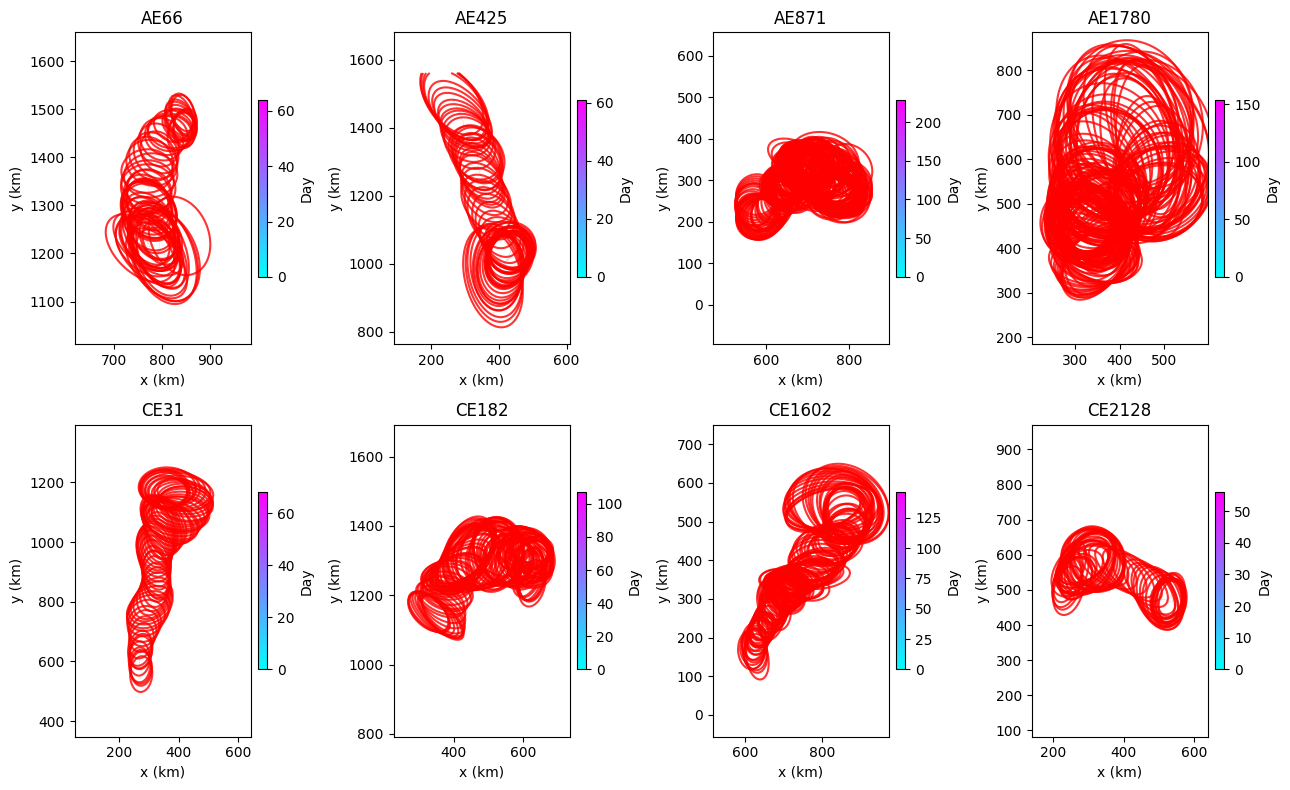

In [16]:
from matplotlib.cm import cool
from matplotlib.colors import Normalize

fig, axs = plt.subplots(2, 4, figsize=(13, 8))

for e, eddy in enumerate(dic_sample):
    if int(eddy[4:]) in [971, 207, 2370]:
        flagx = True
    else:
        flagx = False
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy == int(eddy[4:])]
    xs, ys = df.xc.values, df.yc.values
    Rcs, q11s, q12s, q22s = df.Rc.values, df.q11.values, df.q12.values, df.q22.values
    if not flagx:
        ax.plot(xs, ys, linewidth=.5, color='lightgray', alpha=.7)
        ax.set_xlabel('x (km)')
        ax.set_ylabel('y (km)')
    else:
        ax.plot(ys, xs, linewidth=.5, color='lightgray', alpha=.7)
        ax.set_xlabel('y (km)')
        ax.set_ylabel('x (km)')

    days = np.arange(len(df))
    window = 5
    sq11 = smooth(q11s, days, num=len(days), window=window)
    sq12 = smooth(q12s, days, num=len(days), window=window)
    sq22 = smooth(q22s, days, num=len(days), window=window)

    sRc  = smooth(Rcs,       days, num=len(days), window=window)
    
    norm = Normalize(vmin=days.min(), vmax=days.max())
    cmap = cool
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array(days)

    # for xi, yi, a, b, c, scale, day in zip(xs, ys, sq11, sq12, sq22, sR, days):
        # Qm = np.array([[a, b], [b, c]])
        # xe, ye = plot_ellipse(Qm, (xi, yi), scale=scale)
        # if not flagx:
        #     ax.plot(xe, ye, color=cmap(norm(day)), alpha=.8)
        # else:
        #     ax.plot(ye, xe, color=cmap(norm(day)), alpha=.8)

    for xc, yc, q11, q12, q22, Rc, day in zip(xs, ys, sq11, sq12, sq22, sRc, days):

        dx, dy = X_grid - xc, Y_grid - yc
        if not flagx:
            rho2 = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
            # ax.contour(X_grid, Y_grid, rho2, levels=[Rc**2/2], colors=cmap(norm(day)), linestyles='-', alpha=.8)
            ax.contour(X_grid, Y_grid, rho2, levels=[Rc**2/2], colors='r', linestyles='-', alpha=.8)
        # else:
        #     rho2 = q22*dx**2 + 2*q12*dx*dy + q11*dy**2
        #     ax.contour(Y_grid, X_grid, rho2, levels=[Rc**2/2], colors=cmap(norm(day)), linestyles='-', alpha=.8)

    cbar = fig.colorbar(
        sm, ax=ax,
        orientation='vertical',
        fraction=0.046,
        pad=0.04
    )
    cbar.set_label('Day')
    cbar.ax.yaxis.set_ticks_position('right')
    cbar.ax.yaxis.set_label_position('right')
    gap = 100
    ax.axis('equal'); ax.set_xlim(xs.min()-gap, xs.max()+gap); ax.set_ylim(ys.min()-gap, ys.max()+gap)
    cyc = df_eddies.loc[df_eddies.Eddy == int(eddy[4:]), 'Cyc'].iloc[0]
    ax.set_title(f'{cyc}{eddy[4:]}')

plt.tight_layout()
plt.show()


In [17]:
def km_to_lon(km, lat):
    R_earth = 6371.0
    return km / ((np.pi/180) * R_earth * np.cos(np.radians(lat)))
    

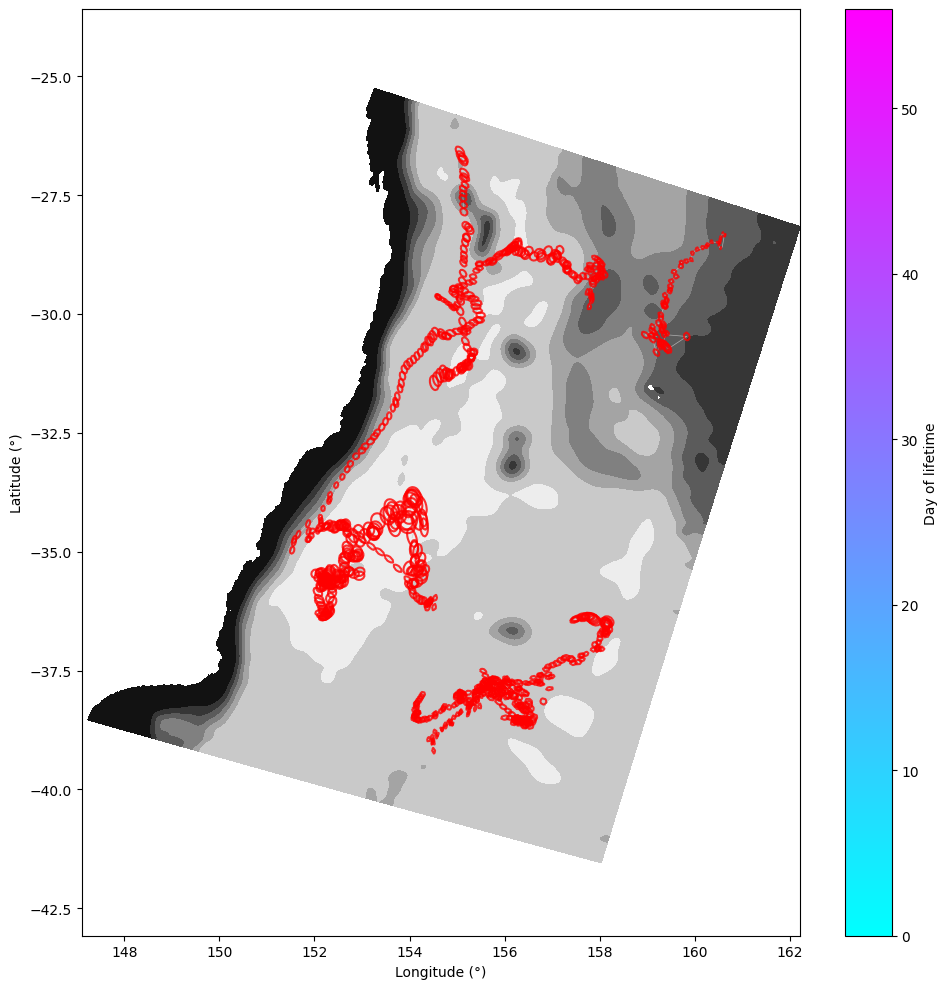

In [18]:
from matplotlib.cm import cool
from matplotlib.colors import Normalize

fig, ax = plt.subplots(figsize=(10,10))

# background bathymetry in km
cs = ax.contourf(lon_rho, lat_rho, np.where(mask_rho, h, np.nan)/1000, cmap='gray')
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Latitude (°)')

for eddy in dic_sample:
    df = df_eddies[df_eddies.Eddy == int(eddy[4:])]
    xs, ys = df.Lon.values, df.Lat.values
    Rcs, q11s, q12s, q22s = df.Rc.values, df.q11.values, df.q12.values, df.q22.values

    # plot trajectory
    ax.plot(xs, ys, linewidth=0.5, color='lightgray', alpha=0.7)

    # smooth covariance terms
    days = np.arange(len(df))
    window = 5
    sq11 = smooth(q11s, days, num=len(days), window=window)
    sq12 = smooth(q12s, days, num=len(days), window=window)
    sq22 = smooth(q22s, days, num=len(days), window=window)
    sRc  = smooth(Rcs,  days, num=len(days), window=window)

    # colormap by lifetime day
    norm = Normalize(vmin=days.min(), vmax=days.max())
    cmap = cool
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])

    for xc, yc, q11, q12, q22, Rc, day in zip(xs, ys, sq11, sq12, sq22, sRc, days):

        dx, dy = lon_rho - xc, lat_rho - yc
        if not flagx:
            rho2 = q11*dx**2 + 2*q12*dx*dy + q22*dy**2
            ax.contour(lon_rho, lat_rho, rho2, levels=[(km_to_lon(Rc, yc)/10)**2/2], colors='r', linestyles='-', alpha=.8)

ax.axis('equal')
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Day of lifetime")

plt.tight_layout()
plt.show()


#### Propogation

#### Volitility

In [19]:
diffs_x = {}
diffs_y = {}

depth_int = 10
max_depth = 4740
target_depths = np.arange(0, max_depth+1, depth_int)

for eddy, dic in dic_sample.items():
    for d, (day, df0) in enumerate(dic.items()):
        df = df0.copy()
        df['Depth'] = -df['Depth']
        df = df[df['Depth'] <= max_depth]
        df = df.set_index('Depth').sort_index()

        key = f'{eddy}_Day{d}'
        if len(df) < 2:
            idx = target_depths[:-1]
            diffs_x[key] = pd.Series(np.nan, index=idx)
            diffs_y[key] = pd.Series(np.nan, index=idx)
            continue

        depths = df.index.values

        # interpolate but mask values outside the data range
        x_i = np.interp(target_depths, depths, df['x'].values,
                        left=np.nan, right=np.nan)
        y_i = np.interp(target_depths, depths, df['y'].values,
                        left=np.nan, right=np.nan)

        dx = np.diff(x_i)
        dy = np.diff(y_i)
        idx = target_depths[:-1]

        diffs_x[key] = pd.Series(dx, index=idx)
        diffs_y[key] = pd.Series(dy, index=idx)

# build DataFrames; reindex will keep NaN for missing bins
full_idx = target_depths[:-1]
df_X_all = pd.DataFrame(diffs_x).reindex(full_idx)
df_Y_all = pd.DataFrame(diffs_y).reindex(full_idx)


In [20]:
df_X_all


,Eddy66_Day0,Eddy66_Day1,Eddy66_Day2,Eddy66_Day3,Eddy66_Day4,Eddy66_Day5,Eddy66_Day6,Eddy66_Day7,Eddy66_Day8,Eddy66_Day9,...,Eddy2128_Day47,Eddy2128_Day48,Eddy2128_Day49,Eddy2128_Day50,Eddy2128_Day51,Eddy2128_Day52,Eddy2128_Day53,Eddy2128_Day54,Eddy2128_Day55,Eddy2128_Day56
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,0.223432,0.583681,0.437549,-0.340328,NaN,-0.000370,0.418030,0.961616,0.582214,-0.158452,...,0.948307,-0.396291,-0.335337,-1.954280,NaN,-2.619292,-0.134608,-0.020044,-0.053322,-0.052644
20,0.183578,0.474423,0.898089,0.217404,NaN,-0.047415,0.185783,0.739737,0.407410,-0.277979,...,0.441442,-1.513419,-0.197551,-1.242789,NaN,-0.083011,0.035272,-0.163495,-0.180367,-0.648340
30,0.261235,0.404979,0.121508,0.138014,NaN,-0.112794,0.207863,0.300438,0.111034,-0.968902,...,-0.056505,-1.058815,-0.438449,-0.633817,NaN,-0.112412,-0.053428,0.005251,-0.225293,-1.064292
40,0.382620,0.072242,0.075364,0.015412,NaN,-0.239971,0.376057,0.010594,0.243767,0.055333,...,-0.071479,-0.392653,-0.323550,-0.676235,NaN,-0.054765,-0.087383,0.026369,-0.341849,-0.505497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4690,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4700,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
df_data = pd.DataFrame()
for eddy in dic_sample.keys():
    df_eddy_x = df_X_all[[col for col in df_X_all.columns if eddy in col]].copy()
    df_data[f'x_{eddy}_mean'] = df_eddy_x.mean(axis=1)
    df_data[f'x_{eddy}_std'] = df_eddy_x.std(axis=1)
    df_eddy_y = df_Y_all[[col for col in df_Y_all.columns if eddy in col]].copy()
    df_data[f'y_{eddy}_mean'] = df_eddy_y.mean(axis=1)
    df_data[f'y_{eddy}_std'] = df_eddy_y.std(axis=1)
df_data.head()


,x_Eddy66_mean,x_Eddy66_std,y_Eddy66_mean,y_Eddy66_std,x_Eddy425_mean,x_Eddy425_std,y_Eddy425_mean,y_Eddy425_std,x_Eddy871_mean,x_Eddy871_std,...,y_Eddy182_mean,y_Eddy182_std,x_Eddy1602_mean,x_Eddy1602_std,y_Eddy1602_mean,y_Eddy1602_std,x_Eddy2128_mean,x_Eddy2128_std,y_Eddy2128_mean,y_Eddy2128_std
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,0.718666,2.783102,-1.310526,3.960246,-0.342601,1.402302,-0.420409,2.561663,0.854883,2.176525,...,0.328632,2.678106,-0.653854,2.011453,0.253282,1.746391,-0.531063,0.989098,0.195380,2.155990
20,0.359149,1.888230,-0.349585,2.547822,-0.122813,0.967007,-0.370452,1.926738,0.591615,1.589178,...,-0.152458,1.683845,-0.459136,1.165732,0.083050,0.972044,-0.299795,0.571631,0.129359,0.844281
30,0.838781,3.072576,-0.652971,3.581382,-0.197080,0.902594,-0.046993,1.604397,0.432805,1.052969,...,-0.130621,1.003779,-0.371487,1.260428,-0.045296,0.885756,-0.201362,0.367828,0.052279,0.523427
40,-0.030401,3.453639,-0.474009,3.035124,-0.117464,0.847966,-0.036647,1.629920,0.235494,0.746405,...,0.005483,0.481155,-0.149709,1.227789,-0.075156,0.893774,-0.126164,0.300798,0.016954,0.402916


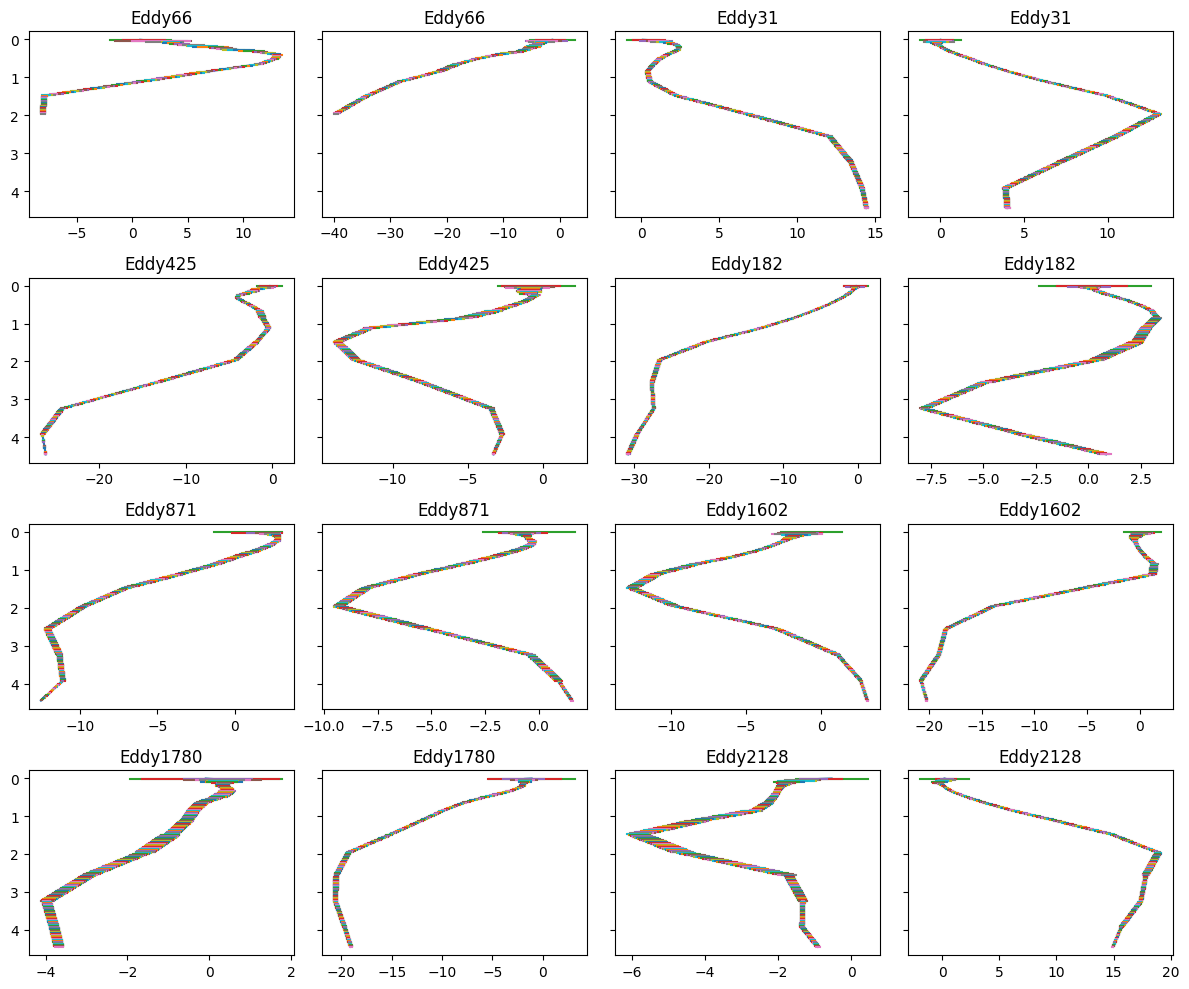

In [22]:
fig, axs = plt.subplots(4,4, figsize=(12,10), sharey=True)
for e, eddy in enumerate(dic_sample.keys()):
    ax0 = axs[e % 4, (e//4)*2]
    ax1 = axs[e % 4, 1+(e//4)*2]

    ax0.set_title(eddy)
    ax1.set_title(eddy)

    x_mean = df_data[f'x_{eddy}_mean']
    x_std = df_data[f'x_{eddy}_std']
    y_mean = df_data[f'y_{eddy}_mean']
    y_std = df_data[f'y_{eddy}_std']

    ax0.plot(x_mean.cumsum(), df_data.index/1000)
    for (r, x, z) in zip(x_std, x_mean.cumsum(), df_data.index/1000):
        ax0.plot([x-r, x+r], [z, z])
    ax1.plot(y_mean.cumsum(), df_data.index/1000)
    for (r, y, z) in zip(y_std, y_mean.cumsum(), df_data.index/1000):
        ax1.plot([y-r, y+r], [z, z])

axs[0,0].invert_yaxis()
plt.tight_layout()


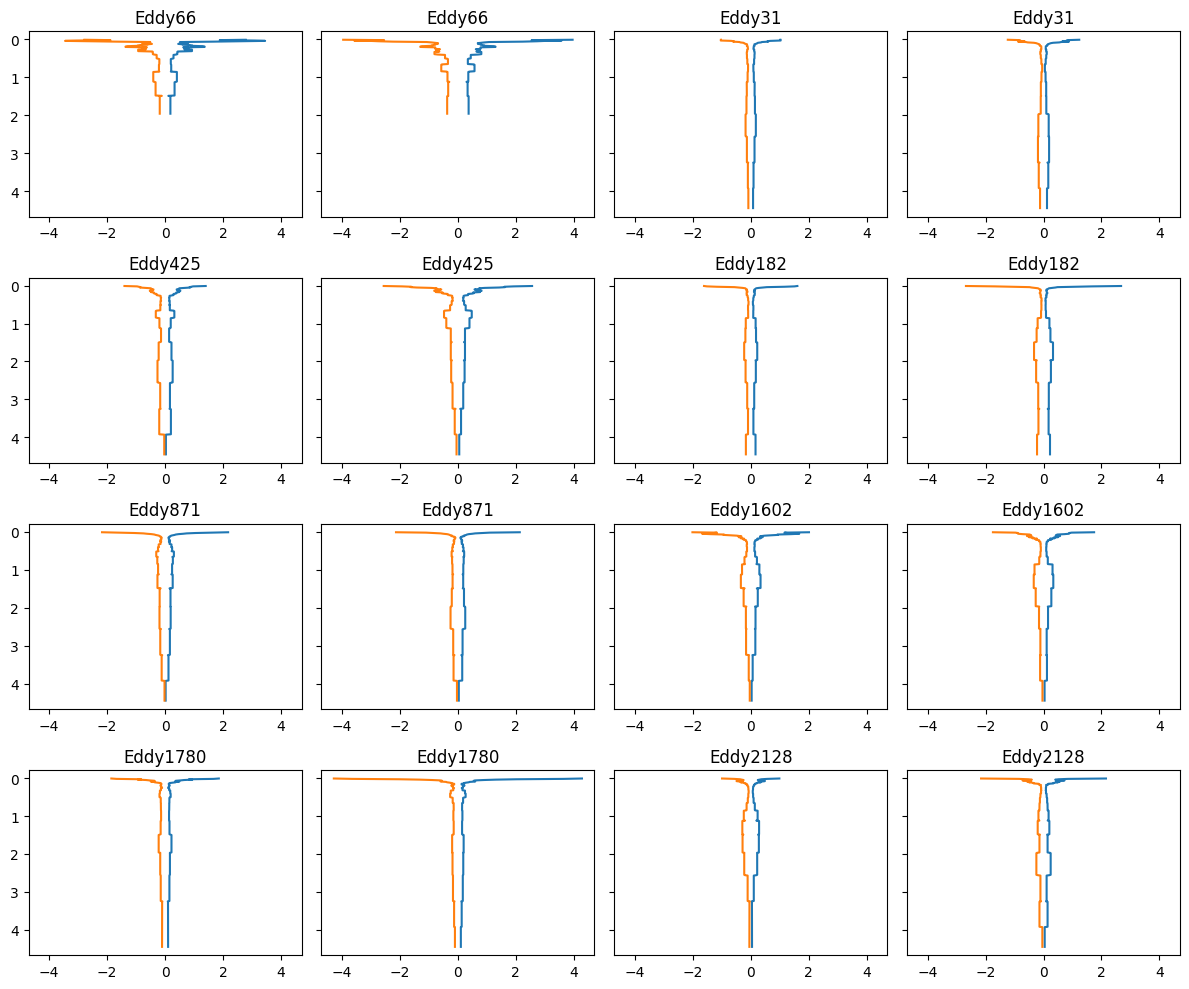

In [23]:
fig, axs = plt.subplots(4,4, figsize=(12,10), sharey=True)
xmax = 0
for e, eddy in enumerate(dic_sample.keys()):
    ax0 = axs[e % 4, (e//4)*2]
    ax1 = axs[e % 4, 1+(e//4)*2]

    ax0.set_title(eddy)
    ax1.set_title(eddy)

    x_mean = df_data[f'x_{eddy}_mean']
    x_std = df_data[f'x_{eddy}_std']
    y_mean = df_data[f'y_{eddy}_mean']
    y_std = df_data[f'y_{eddy}_std']

    ax0.plot(x_std, df_data.index/1000)
    ax0.plot(-x_std, df_data.index/1000)
    ax1.plot(y_std, df_data.index/1000)
    ax1.plot(-y_std, df_data.index/1000)

    xmax = max(xmax, ax0.get_xlim()[1], ax1.get_xlim()[1])
for ax in axs.flat:
    ax.set_xlim(-xmax, xmax)

axs[0,0].invert_yaxis()
plt.tight_layout()


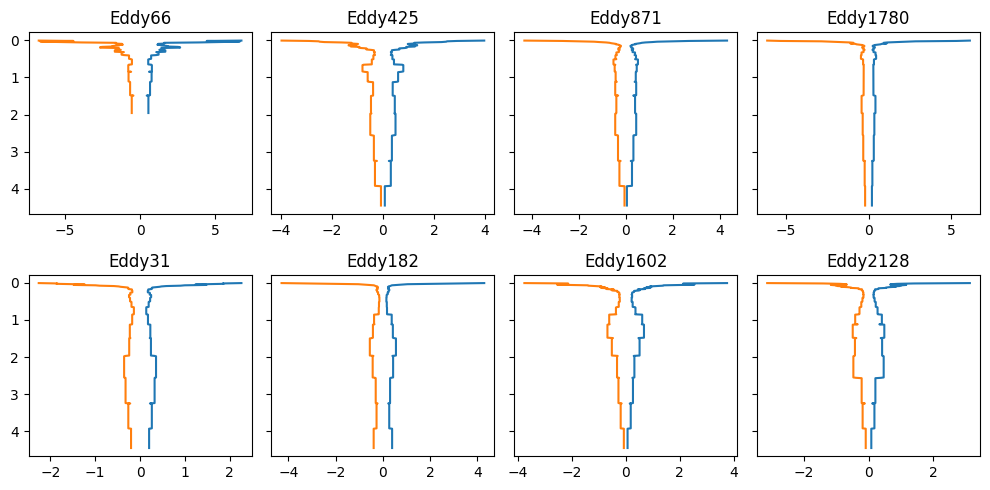

In [24]:
fig, axs = plt.subplots(2, 4, figsize=(10,5), sharey=True)     
for e, eddy in enumerate(dic_sample.keys()):
    ax = axs[e // 4, e % 4]
    ax.set_title(eddy)

    x_mean = df_data[f'x_{eddy}_mean']
    x_std = df_data[f'x_{eddy}_std']
    y_mean = df_data[f'y_{eddy}_mean']
    y_std = df_data[f'y_{eddy}_std']

    ax.plot(x_std+y_std, df_data.index/1000)
    ax.plot(-x_std-y_std, df_data.index/1000)

axs[0,0].invert_yaxis()
plt.tight_layout()


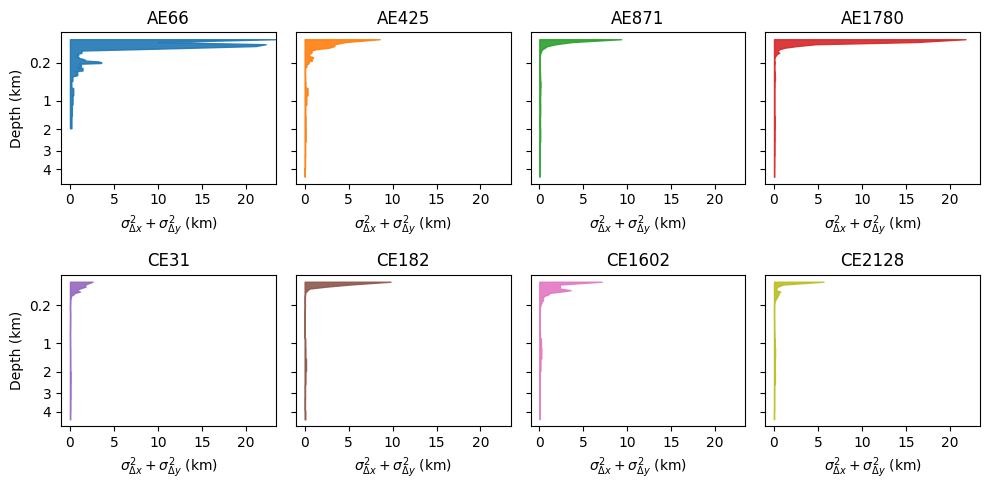

In [25]:
fig, axs = plt.subplots(2, 4, figsize=(10,5), sharey=True)
xmax = 0

# choose a stretch (0<gamma<1). sqrt == gamma=0.5
gamma = 0.5

# precompute tick mapping (same for all subplots)
depth_real = (df_data.index / 1000).values
dmin, dmax = depth_real.min(), depth_real.max()
def stretch(d): return (d - dmin)**gamma
# tick_depths = np.arange(5) 
tick_depths = [.2, 1, 2, 3, 4]
tick_pos = stretch(tick_depths)

for e, eddy in enumerate(dic_sample.keys()):
    ax = axs[e // 4, e % 4]
    cyc = df_eddies[df_eddies.Eddy==int(eddy[4:])].iloc[0].Cyc
    ax.set_title(f'{cyc}{int(eddy[4:])}')

    x_std = df_data[f'x_{eddy}_std'].values
    y_std = df_data[f'y_{eddy}_std'].values
    total_std = x_std**2 + y_std**2

    ax.fill_betweenx(stretch(depth_real), 0, total_std, color=colors[e], alpha=0.9)
    # ax.axhline(y=stretch(.2), lw=.5, ls='--', color='r')
    xmax = max(xmax, np.nanmax(total_std))

for ax in axs.flat:
    ax.set_xlim(-1, xmax)
    ax.set_yticks(tick_pos)
    ax.set_yticklabels([f'{d}' for d in tick_depths])
    ax.set_xlabel(r'$\sigma^2_{\Delta x}+\sigma^2_{\Delta y}$ (km)')
axs[0,0].set_ylabel('Depth (km)')
axs[1,0].set_ylabel('Depth (km)')

axs[0,0].invert_yaxis()
plt.tight_layout()



#### Velocity Field

In [26]:
fnumber_old = 0

In [27]:
day_idx_p = [26, 17, 5, 51, 
             68, 89, 114, 40]

In [28]:
# Unique colors for each eddy
colors = [c for i, c in enumerate(plt.get_cmap("tab10").colors) if i != 7]


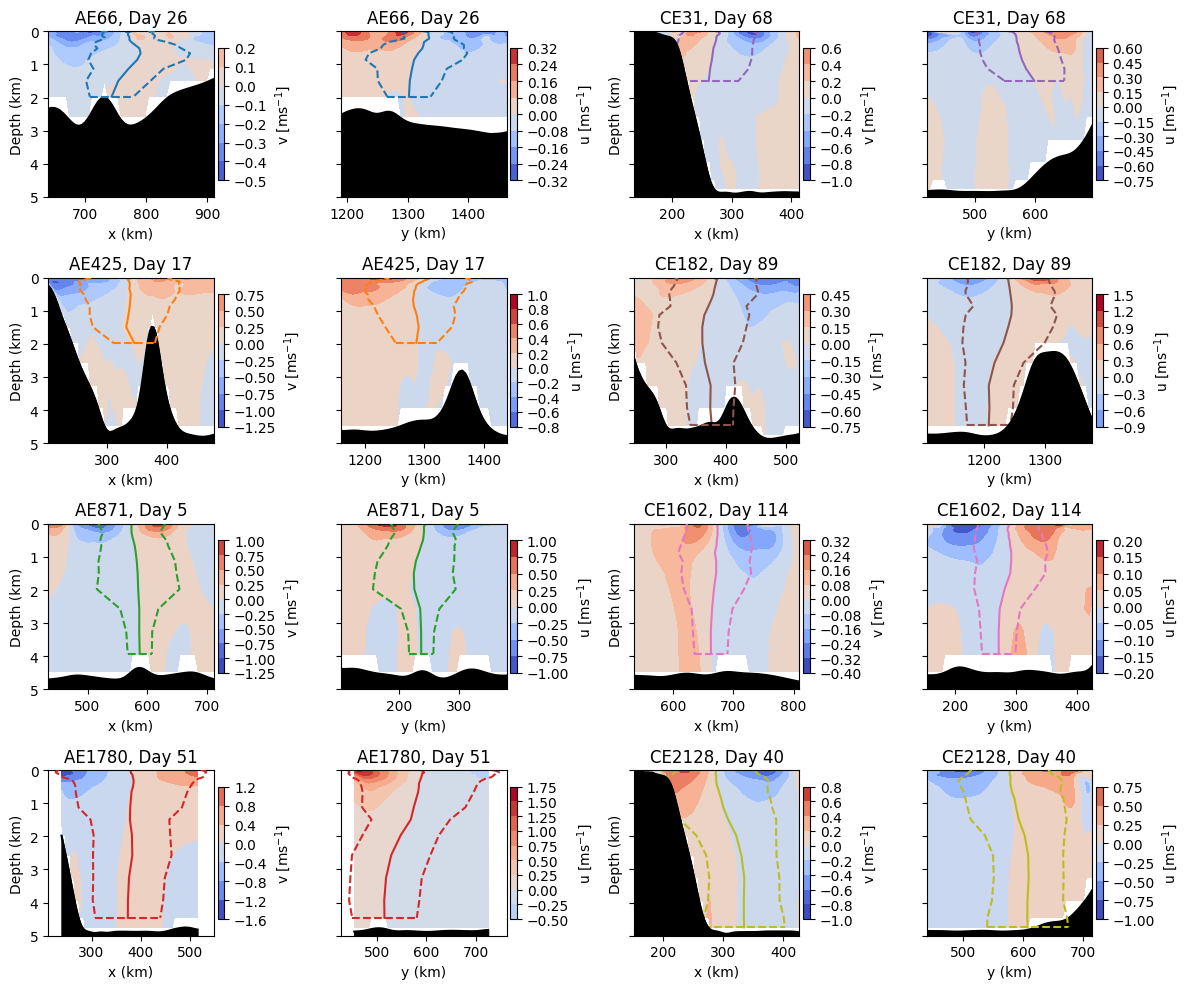

In [29]:
fig, axs = plt.subplots(4, 4, figsize=(12,10), sharey=True)
# colors = plt.get_cmap('tab10').colors
fnumber_old = None

for e, (eddy, day_idx) in enumerate(zip(sample_eddies, day_idx_p)):
    
    ax0 = axs[e % 4, (e//4)*2]
    ax1 = axs[e % 4, 1+(e//4)*2]
    r = 140 if eddy != 1978 else 200

    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax0.set_title(f'{cyc}{eddy}, Day {day_idx}')
    ax1.set_title(f'{cyc}{eddy}, Day {day_idx}')
    
    dic = dic_sample[f'Eddy{eddy}']
    day = list(dic.keys())[day_idx]
    df = dic[day].copy()

    # Rs = df.R.values.copy()
    # depths = -df.Depth.values.copy() / 1000  # in km
    # df['sR']   = smooth(Rs, depths, window=50, num=1000)

    day = int(day[3:])
        
    fname = df_eddies[(df_eddies.Eddy==eddy)&(df_eddies['Day']==day)].iloc[0]['fname']
    fnumber = fname[-8:-3]
    if fnumber != fnumber_old:
    
        u_raw = np.load('/srv/scratch/z5297792/Climatology/u_v/u_' + fnumber + '.npy')
        v_raw = np.load('/srv/scratch/z5297792/Climatology/u_v/v_' + fnumber + '.npy')
        
        u_raw = np.where(np.abs(u_raw) > 1e30, np.nan, u_raw).astype(float)
        v_raw = np.where(np.abs(v_raw) > 1e30, np.nan, v_raw).astype(float)
        
        with nc.Dataset(fname) as dataset:
            ocean_time = dataset.variables['ocean_time'][:].data / 86400
        fnumber_old = fnumber
    t_rel = np.where(ocean_time == day)[0][0]
    
    u_t, v_t = u_raw[:, :, :, t_rel], v_raw[:, :, :, t_rel]
    
    xc_surf, yc_surf = df.iloc[0].x, df.iloc[0].y
    ic = np.where(np.abs(x_grid-xc_surf)==np.min(np.abs(x_grid-xc_surf)))[0][0]
    jc = np.where(np.abs(y_grid-yc_surf)==np.min(np.abs(y_grid-yc_surf)))[0][0]
    
    x_mask = np.where(np.abs(x_grid - xc_surf) < r)[0]
    y_mask = np.where(np.abs(y_grid - yc_surf) < r)[0]
    
    # symmetric limits
    vmax_v = np.nanmax(np.abs(v_t[x_mask, jc, :]))
    vmax_u = np.nanmax(np.abs(u_t[ic, y_mask, :]))
    
    # v‐slice
    im0 = ax0.contourf(
        x_grid[x_mask],
        -z_r/1000,
        v_t[x_mask, jc, :].T,
        cmap='coolwarm',
        vmin=-vmax_v,
        vmax=+vmax_v,
        zorder=0
    )
    ax0.plot(df.x, -df.Depth/1000, color=colors[e%len(colors)])
    ax0.plot(df.x+df.sR, -df.Depth/1000, color=colors[e%len(colors)], ls='--',
            zorder=1 if df.iloc[-1].y > y_grid[jc] else 3)
    ax0.plot(df.x-df.sR, -df.Depth/1000, color=colors[e%len(colors)], ls='--',
            zorder=1 if df.iloc[-1].y > y_grid[jc] else 3)
    ax0.plot([df.iloc[-1].x-df.iloc[-1].sR, df.iloc[-1].x+df.iloc[-1].sR],
             [-df.iloc[-1].Depth/1000, -df.iloc[-1].Depth/1000],
             color=colors[e%len(colors)], ls='--', zorder=1 if df.iloc[-1].y > y_grid[jc] else 3)
    ax0.set_xlabel('x (km)')
    ax0.set_ylabel('Depth (km)')
    ax0.plot(x_grid[x_mask], h[x_mask, jc]/1000, 'k', zorder=2)
    ax0.fill_between(x_grid[x_mask], h[x_mask, jc]/1000, 10, color='k', zorder=2)
    ax0.set_ylim(ax0.get_ylim())
    
    # vertical colourbar on the right
    cbar0 = fig.colorbar(
        im0,
        ax=ax0,
        orientation='vertical',  # default but explicit here
        pad=0.02,                # small gap to the right
        shrink=0.8               # scale to fit subplot height
    )
    cbar0.set_label(r'v [ms$^{-1}$]')
    
    # u‐slice
    im1 = ax1.contourf(
        y_grid[y_mask],
        -z_r/1000,
        u_t[ic, y_mask, :].T,
        cmap='coolwarm',
        vmin=-vmax_u,
        vmax=+vmax_u,
        zorder=0
    )
    ax1.plot(df.y, -df.Depth/1000, color=colors[e])
    ax1.plot(df.y+df.sR, -df.Depth/1000, color=colors[e%len(colors)], ls='--',
            zorder=1 if df.iloc[-1].x < x_grid[ic] else 3)
    ax1.plot(df.y-df.sR, -df.Depth/1000, color=colors[e%len(colors)], ls='--',
            zorder=1 if df.iloc[-1].x < x_grid[ic] else 3)
    ax1.plot([df.iloc[-1].y-df.iloc[-1].sR, df.iloc[-1].y+df.iloc[-1].sR],
             [-df.iloc[-1].Depth/1000, -df.iloc[-1].Depth/1000], 
             color=colors[e%len(colors)], ls='--', zorder=1 if df.iloc[-1].x < x_grid[ic] else 3)
    ax1.set_xlabel('y (km)')
    ax1.plot(y_grid[y_mask], h[ic, y_mask]/1000, 'k', zorder=2)
    ax1.fill_between(y_grid[y_mask], h[ic, y_mask]/1000, 10, color='k', zorder=2)
    ax1.set_ylim(0, 5)
    
    # vertical colourbar on the right
    cbar1 = fig.colorbar(
        im1,
        ax=ax1,
        orientation='vertical',
        pad=0.02,
        shrink=0.8
    )
    cbar1.set_label(r'u [ms$^{-1}$]')

# invert y once at the end
axs[0,0].invert_yaxis()
plt.tight_layout()
plt.show()


### Eddy propogation

In [30]:
sample_set = set(sample_eddies)

# EddyProp
eddy_props = []
for eddy in df_eddies.Eddy.unique():
    if eddy not in sample_set:
        eddy_props.extend([np.nan] * df_eddies[df_eddies.Eddy==eddy].shape[0])
        continue
    df = df_eddies[df_eddies.Eddy==eddy]
    eddy_props.extend(np.hypot(df.xc.diff(), df.yc.diff()) * 0.011574)
df_eddies['EddyProp'] = eddy_props

# displacement of top centre
dxs, dys = [], []
for eddy in df_eddies.Eddy.unique():
    df = df_eddies[df_eddies.Eddy==eddy]
    if eddy not in sample_set:
        dxs.extend([np.nan] * df.shape[0])
        dys.extend([np.nan] * df.shape[0])
        continue
    dxs.extend(df.xc.diff())
    dys.extend(df.yc.diff())
df_eddies['dx_top'] = dxs
df_eddies['dy_top'] = dys

# bottom propagation
df_idx = df_eddies.set_index(['Eddy', 'Day'])
eddy_btm_prop = []
for eddy, dic in dic_eddies_vert.items():
    eddy_id = int(eddy[4:])
    if eddy_id not in sample_set:
        n = len(dic)
        eddy_btm_prop.extend([np.nan] * n)
        continue
    x_btms, y_btms = [], []
    for day, df in dic.items():
        if len(df):
            df = df[df.Depth.abs() < 1000]
            d = df.iloc[-1]
            xc, yc = d.x, d.y
        else:
            d = df_idx.loc[(eddy_id, int(day[3:]))]
            xc, yc = d.xc, d.yc
        x_btms.append(xc)
        y_btms.append(yc)
    disp = np.hypot(np.diff(x_btms), np.diff(y_btms)) * 0.011574
    disp = np.insert(disp, 0, np.nan)
    eddy_btm_prop.extend(disp)
df_eddies['btm_prop'] = eddy_btm_prop

# displacement of bottom centre
dxs, dys = [], []
for eddy, dic in dic_eddies_vert.items():
    eddy_id = int(eddy[4:])
    if eddy_id not in sample_set:
        n = len(dic)
        dxs.extend([np.nan] * n)
        dys.extend([np.nan] * n)
        continue
    x_btms, y_btms = [], []
    for day, df in dic.items():
        if len(df):
            df = df[df.Depth.abs() < 1000]
            d = df.iloc[-1]
            xc, yc = d.x, d.y
        else:
            d = df_idx.loc[(eddy_id, int(day[3:]))]
            xc, yc = d.xc, d.yc
        x_btms.append(xc)
        y_btms.append(yc)
    dx = np.insert(np.diff(x_btms), 0, np.nan)
    dy = np.insert(np.diff(y_btms), 0, np.nan)
    dxs.extend(dx)
    dys.extend(dy)
df_eddies['dx_btm'] = dxs
df_eddies['dy_btm'] = dys

df_eddies['top_btm_diff'] = np.hypot(df_eddies.dx_btm - df_eddies.dx_top,
                                     df_eddies.dy_btm - df_eddies.dy_top) * 0.011574


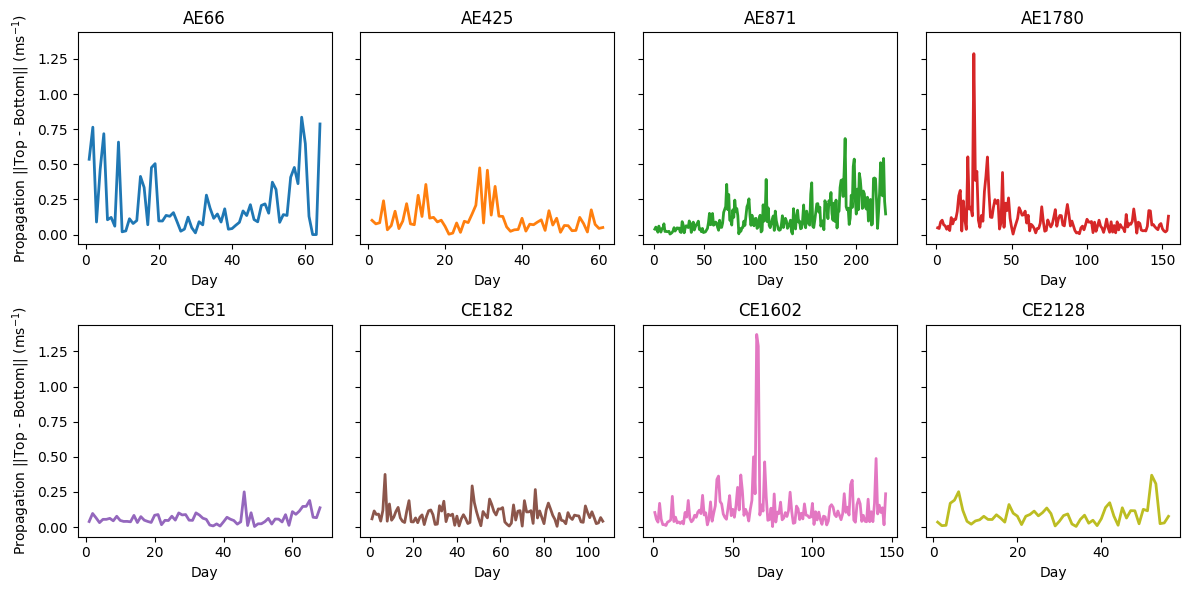

In [32]:
fig, axs = plt.subplots(2, 4, figsize=(12,6), sharey=True)

for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy==eddy]
    # ax.plot(df.Day-df.Day.iloc[0], df.EddyProp)
    # ax.plot(df.Day-df.Day.iloc[0], df.btm_prop)
    
    ax.plot(df.Day-df.Day.iloc[0], df.top_btm_diff,
           color=colors[e], lw=2)
    # ax.axhline(y=0, lw=.75, color='k')
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_xlabel('Day'); ax.set_title(f'{cyc}{eddy}')
    
axs[0,0].set_ylabel(r'Propagation ||Top - Bottom|| (ms$^{-1}$)')
axs[1,0].set_ylabel(r'Propagation ||Top - Bottom|| (ms$^{-1}$)')
plt.tight_layout()


(np.float64(-325.6624501305554),
 np.float64(244.66362363735655),
 np.float64(-656.3706213187713),
 np.float64(232.029256727124))

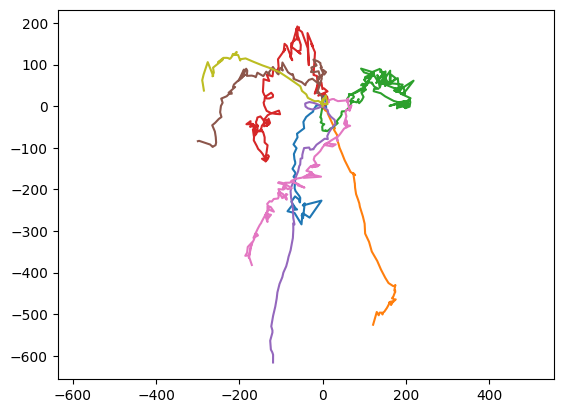

In [33]:
for e, eddy in enumerate(sample_eddies):
    df = df_eddies[df_eddies.Eddy==eddy]
    plt.plot(df.xc-df.iloc[0].xc, df.yc-df.iloc[0].yc, color=colors[e])
plt.axis('equal')
    

### Plan View

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y

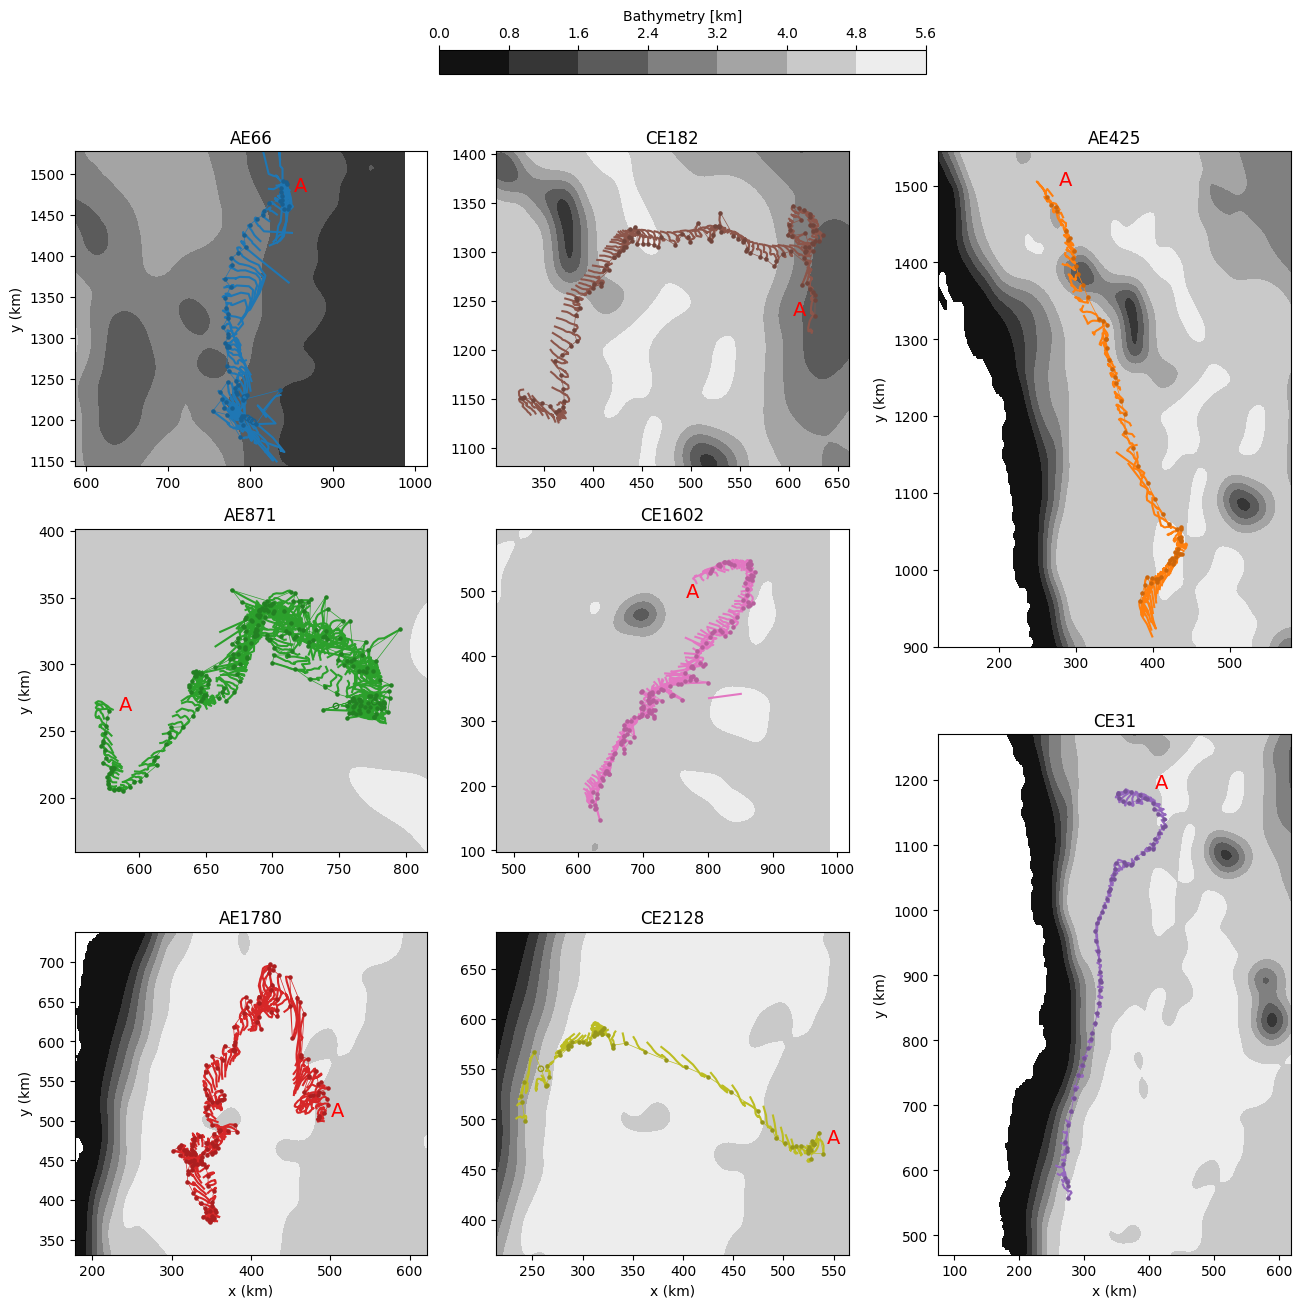

In [34]:
from matplotlib.colors import to_rgb
def darken(color, factor=0.7):
    r, g, b = to_rgb(color)
    return (r*factor, g*factor, b*factor)

fig = plt.figure(figsize=(13, 13), constrained_layout=True)
gs = fig.add_gridspec(6, 3)

gap = 5
mappable = None
s = 5

# slots for all non-special eddies on a 6x3 grid (left two columns)
# roughly mimics a 3x2 layout: rows 0,2,4
normal_slots = [
    (0, 0), (2, 0), (4, 0),
    (0, 1), (2, 1), (4, 1),
]

k = 0
axes_list = []
for e, eddy in enumerate(sample_eddies):

    # eddy 1 and 4 get tall panels in the right column
    if e == 1:
        ax = fig.add_subplot(gs[0:3, 2])   # top-right, 1.5 "rows" tall
        axes_list.append(ax)
        col = 2
        row = 0
        is_tall = True
        ax.set_ylabel('y (km)')
    elif e == 4:
        ax = fig.add_subplot(gs[3:6, 2])   # bottom-right, 1.5 "rows" tall
        axes_list.append(ax)
        col = 2
        row = 4
        is_tall = True
        ax.set_xlabel('x (km)')
        ax.set_ylabel('y (km)')
    else:
        row, col = normal_slots[k]
        k += 1
        ax = fig.add_subplot(gs[row:row+2, col])
        axes_list.append(ax)
        is_tall = False

    df = df_eddies[df_eddies.Eddy == eddy]
    m = ax.contourf(X_grid, Y_grid, np.where(mask_rho, h/1e3, np.nan), cmap='gray')
    if mappable is None:
        mappable = m

    df_eddy = df_eddies[df_eddies.Eddy == eddy]
    ax.plot(df_eddy.xc, df_eddy.yc, color=colors[e], linewidth=.5, zorder=1)
    flg = True
    for d, day in enumerate(df['Day'].unique()):
        data = df[df.Day == day]

        plot_data = df_eddies[(df_eddies.Eddy == eddy) & (df_eddies['Day'] == int(day))]
        x0, y0 = plot_data.iloc[0].xc, plot_data.iloc[0].yc
        
        df_vert = dic_sample[f'Eddy{eddy}'][f'Day{day}'].copy()
        df_vert = df_vert[df_vert.Depth.abs() < 1000]
        
        cyc = df_eddies[df_eddies.Eddy == eddy].Cyc.iloc[0]

        if len(df_vert):
            if flg:
                ax.plot(df_vert.x, df_vert.y, color=colors[e], zorder=2,
                    label=f'{cyc}{eddy}')
                flg = False
            else:
                ax.plot(df_vert.x, df_vert.y, color=colors[e], zorder=2)
            ax.scatter(x0, y0, color=darken(colors[e % len(colors)], 0.8),
                   s=s, zorder=3)
        else:
            ax.scatter(x0, y0, color=darken(colors[e % len(colors)], 0.8),
                       s=15, zorder=3, facecolors='none')

    if eddy==1602:
        a, b = -2.5, -2.5
    elif eddy==1780:
        a, b = 1, 0
    elif eddy==182:
        a, b = -1.5, 0
    elif eddy==871:
        a, b = .5, 0
    else:
        a, b = 1, 1
        
    ax.text(df_eddy.iloc[0].xc+a*15, df_eddy.iloc[0].yc+b*15, 'A',
            color='r', fontsize=14)
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.axis('equal'); ax.set_title(f'{cyc}{eddy}')
    ax.set_xlim(df_eddy.xc.min() - gap, df_eddy.xc.max() + gap)
    ax.set_ylim(df_eddy.yc.min() - gap, df_eddy.yc.max() + gap)

    # axis labels: left column gets y, bottom band gets x
    if col == 0:
        ax.set_ylabel('y (km)')
    # bottom "row" for small plots (row==4) and the lower tall panel (eddy 4)
    if (not is_tall and row == 4) or (is_tall and e == 4):
        ax.set_xlabel('x (km)')

cbar = fig.colorbar(mappable, ax=axes_list, location='top', shrink=0.4)
cbar.set_label('Bathymetry [km]')
